# Read_Data

In [808]:
import numpy as np
import pandas as pd 

from sklearn import datasets
from sklearn.model_selection import StratifiedShuffleSplit

np.random.seed(42)

In [809]:
iris = datasets.load_iris()
X = iris["data"]
y = iris["target"]
df = pd.DataFrame({fname: values for fname, values in zip(iris["feature_names"], X.T)})
df["target"] = y

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [810]:
X.shape

(150, 4)

# Split_data

In [811]:
split = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["target"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
    


In [812]:
X_train,y_train=strat_train_set.iloc[:,[0,1,2,3]],strat_train_set.iloc[:,4]

In [813]:
X_test,y_test=strat_test_set.iloc[:,[0,1,2,3]],strat_test_set.iloc[:,4]
X_test=np.array(X_test)
y_test=np.array(y_test)

In [814]:
X_train=np.array(X_train)
X_train.shape

(120, 4)

In [815]:
y_train=np.array(y_train)
y_train.shape

(120,)

# One_hot _encoding

In [816]:
from sklearn.preprocessing import OneHotEncoder 
en=OneHotEncoder(sparse=False)
y_train_encoded=en.fit_transform(y_train.reshape(-1,1))
y_train_encoded.shape

(120, 3)

# Soft_max_implmention

In [817]:
def soft_max(z):
    exp=np.exp(z-np.max(z))
    for i in range(len(z)):
        exp[i]/=np.sum(exp[i])
    return exp
    

# Mini_batch optimiztion

In [818]:
def generate_mini_batch(x,y,y_encoded,batch_size):
    for i in range(0,len(x),batch_size):
        yield x[i:i+batch_size],y[i:i+batch_size],y_encoded[i:i+batch_size]

In [819]:
def mini_batch_fit(X,y,batch_size,lr,iterations,c):
    m,n=X.shape ##shape of trainning data
    theta=np.random.random((n,c)) ##shape of theta (no of feautures vs no of classes)
    b=np.random.random(c) ##shape of bias is (no of classes vs 1)
    losses=[]
    for i in range(iterations):
        for x_batch,y_batch,y_encoded_batch in generate_mini_batch(X,y,y_train_encoded,batch_size): 
           
            z=x_batch@theta+b  ##hypothesis
            
            y_hat=soft_max(z) ##convert hypothesis to probability
            
            theta_grad=(1/m)*np.dot(x_batch.T,(y_hat-y_encoded_batch)) ##cal theta gradient
            b_grad =(1/m)*np.sum(y_hat - y_encoded_batch)  ##cal bias gradient
            
            theta=theta-lr*theta_grad  ##update theta
            b=b-lr*b_grad            ##update bias
            loss = -np.mean(np.log(y_hat[np.arange(len(y_batch)), y_batch.astype(np.int32)])) ##calculate loss by indexing the probabilites(in yhat)
            #with value equal 1 in y_actual for each row
            
            losses.append(loss)
            if i%100==0:
                print("at {} iteration loss is {}".format(i,loss))
    return theta,b,losses
            
        
            

In [820]:
theta,bias,l=mini_batch_fit(X_train,y_train,24, 0.2, 1000,3)

at 0 iteration loss is 1.1338685775806245
at 0 iteration loss is 1.0291303156232925
at 0 iteration loss is 0.8022123714991455
at 0 iteration loss is 0.7247991194866458
at 0 iteration loss is 0.6784498619944945
at 100 iteration loss is 0.2740025989928258
at 100 iteration loss is 0.1912439191372158
at 100 iteration loss is 0.2902552145743777
at 100 iteration loss is 0.29958872465210823
at 100 iteration loss is 0.25112943098543455
at 200 iteration loss is 0.1966128367392296
at 200 iteration loss is 0.1294441168265366
at 200 iteration loss is 0.23309981118082687
at 200 iteration loss is 0.20848366801903584
at 200 iteration loss is 0.18966550128181803
at 300 iteration loss is 0.1600051857921062
at 300 iteration loss is 0.10031083676337908
at 300 iteration loss is 0.20817223510408353
at 300 iteration loss is 0.1633741779835832
at 300 iteration loss is 0.16056914184804066
at 400 iteration loss is 0.13849069635578257
at 400 iteration loss is 0.08307642656204563
at 400 iteration loss is 0.19453

Text(0, 0.5, 'loss')

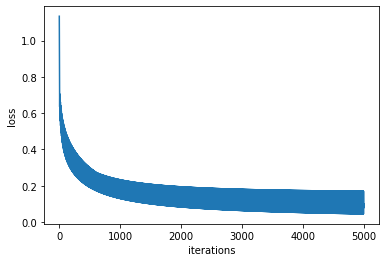

In [837]:
import matplotlib.pyplot as plt
plt.plot(l)
plt.xlabel('iterations')
plt.ylabel('loss')

# Make_predictions

In [822]:
def predict(X,w,b):
    z=X@w+b
    y_hat=soft_max(z)#.values)
    return np.argmax(y_hat,axis=1)

# cal_accuracy

In [823]:
def accuracy(y_pred,y_act):
    return ((np.sum(y_pred==y_act)/len(y_pred))*100)

# Train_acc

In [824]:
print(accuracy(predict(X_train,theta,bias),y_train))

97.5


# Test_acc 

In [825]:
accuracy(predict(X_test,theta,bias),y_test)

90.0

# Cross_validation

In [838]:
Train_data=strat_train_set.iloc[:,[0,1,2,3,4]]

In [839]:
def cross_validation(data,folds):
    data_split=list()
    data_copy=data
    fold_size=int(len(data_copy)/folds)
    for i in range(folds):
        fold=list()
        while len(fold)<fold_size:
            r=randrange(len(data_copy))
            ind=data_copy.index[r]
            fold.append(data_copy.loc[ind].values)
            data_copy=data_copy.drop(ind)
        data_split.append(np.asarray(fold))
    return data_split
def train_test(data,folds):
    for i in range(folds):
        val_set=data[i]
        del data[i]
        train_set=data
        yield val_set,train_set
        data.append(val_set)

In [856]:
data_cv=cross_validation(Train_data,4)
scores=[]
for val_set,train_set in train_test(data_cv,4):
    x_val=val_set[:,0:4]
    y_val=val_set[:,4]
    train=np.vstack(train_set)
    x_train=train[:,0:4]
    y_train=train[:,4]
    theta,b,_=mini_batch_fit(x_train,y_train,5,0.2,10000,3)
    pred =predict(x_val,theta,b)
    scores.append(accuracy(pred,y_val))

at 0 iteration loss is 1.719109762048829
at 0 iteration loss is 1.3403997256240143
at 0 iteration loss is 1.6020838529363541
at 0 iteration loss is 2.094450681878013
at 0 iteration loss is 2.2820095040672164
at 0 iteration loss is 1.41648617457002
at 0 iteration loss is 1.1945263225784433
at 0 iteration loss is 0.9179149229680575
at 0 iteration loss is 1.547463203143402
at 0 iteration loss is 1.1511934347009576
at 0 iteration loss is 1.1620631216362036
at 0 iteration loss is 1.3206007534620814
at 0 iteration loss is 1.0364947271553795
at 0 iteration loss is 1.1735147773950239
at 0 iteration loss is 0.901841610935026
at 0 iteration loss is 1.0668545483960492
at 0 iteration loss is 1.0578214748887622
at 0 iteration loss is 1.0968861140791621
at 100 iteration loss is 0.9573396426435095
at 100 iteration loss is 0.8792790142027019
at 100 iteration loss is 0.9070479850053259
at 100 iteration loss is 0.9248058023766206
at 100 iteration loss is 0.8348325001849691
at 100 iteration loss is 0.965

at 1200 iteration loss is 1.0182311725390005
at 1200 iteration loss is 0.8495339118183427
at 1200 iteration loss is 0.8645220018202642
at 1200 iteration loss is 0.8843908970164863
at 1200 iteration loss is 0.8524693590868748
at 1200 iteration loss is 0.9454011532106102
at 1200 iteration loss is 0.9133042387257937
at 1200 iteration loss is 0.7990413463639056
at 1200 iteration loss is 1.0108263314283732
at 1200 iteration loss is 1.028207640496607
at 1200 iteration loss is 0.9645303452046651
at 1200 iteration loss is 1.0622472024165037
at 1200 iteration loss is 0.867463287858105
at 1200 iteration loss is 0.997926402599863
at 1200 iteration loss is 0.7724260902530675
at 1200 iteration loss is 0.8380766475379087
at 1200 iteration loss is 0.970430125181986
at 1200 iteration loss is 0.950612163209582
at 1300 iteration loss is 1.019802717533291
at 1300 iteration loss is 0.8490279517155166
at 1300 iteration loss is 0.8641921391242391
at 1300 iteration loss is 0.8840396110166271
at 1300 iteratio

at 2300 iteration loss is 1.0269397756204797
at 2300 iteration loss is 0.8467198286185976
at 2300 iteration loss is 0.8627391538787073
at 2300 iteration loss is 0.8825027901159549
at 2300 iteration loss is 0.8561921222259684
at 2300 iteration loss is 0.9427517836548256
at 2300 iteration loss is 0.9099851451786927
at 2300 iteration loss is 0.8015127982119535
at 2300 iteration loss is 1.0139473455076409
at 2300 iteration loss is 1.0209915545931811
at 2300 iteration loss is 0.9652905441112509
at 2300 iteration loss is 1.063098112741786
at 2300 iteration loss is 0.8688394520664942
at 2300 iteration loss is 0.9940086149050609
at 2300 iteration loss is 0.772540802167974
at 2300 iteration loss is 0.8335985971258936
at 2300 iteration loss is 0.9720755501694663
at 2300 iteration loss is 0.9510291449015934
at 2400 iteration loss is 1.0272019467819056
at 2400 iteration loss is 0.8466335647303861
at 2400 iteration loss is 0.862685177147647
at 2400 iteration loss is 0.8824466557666659
at 2400 itera

at 3400 iteration loss is 1.0283940820278328
at 3400 iteration loss is 0.8462349376932226
at 3400 iteration loss is 0.8624338132036229
at 3400 iteration loss is 0.8821879891338844
at 3400 iteration loss is 0.8568214033734234
at 3400 iteration loss is 0.9422982223612604
at 3400 iteration loss is 0.9094332079104206
at 3400 iteration loss is 0.8019612286718243
at 3400 iteration loss is 1.0144757052228783
at 3400 iteration loss is 1.0198488258775176
at 3400 iteration loss is 0.9654617389396607
at 3400 iteration loss is 1.063246263987112
at 3400 iteration loss is 0.869068853323778
at 3400 iteration loss is 0.9933389077479566
at 3400 iteration loss is 0.7725495539009828
at 3400 iteration loss is 0.8328567671986271
at 3400 iteration loss is 0.9723355649458378
at 3400 iteration loss is 0.9511268537295002
at 3500 iteration loss is 1.0284378492981354
at 3500 iteration loss is 0.846219868904382
at 3500 iteration loss is 0.8624241761315303
at 3500 iteration loss is 0.8821782348958449
at 3500 itera

at 4500 iteration loss is 1.0286368719304668
at 4500 iteration loss is 0.8461498704099698
at 4500 iteration loss is 0.862378961185447
at 4500 iteration loss is 0.8821329553305068
at 4500 iteration loss is 0.8569278364425228
at 4500 iteration loss is 0.9422185819076561
at 4500 iteration loss is 0.9093400887742566
at 4500 iteration loss is 0.8020429411085723
at 4500 iteration loss is 1.0145674889518026
at 4500 iteration loss is 1.019668887710458
at 4500 iteration loss is 0.9654951578413631
at 4500 iteration loss is 1.0632681438742768
at 4500 iteration loss is 0.8691060720694074
at 4500 iteration loss is 0.9932237951188219
at 4500 iteration loss is 0.7725478057048268
at 4500 iteration loss is 0.8327319129594624
at 4500 iteration loss is 0.9723762647398437
at 4500 iteration loss is 0.9511492667034316
at 4600 iteration loss is 1.028644182894865
at 4600 iteration loss is 0.8461472028094084
at 4600 iteration loss is 0.8623772095211677
at 4600 iteration loss is 0.8821312312303121
at 4600 itera

at 5700 iteration loss is 1.0286786749196506
at 5700 iteration loss is 0.8461342676705673
at 5700 iteration loss is 0.8623686159092804
at 5700 iteration loss is 0.8821228749795076
at 5700 iteration loss is 0.8569464616408302
at 5700 iteration loss is 0.9422039559212321
at 5700 iteration loss is 0.9093238040392005
at 5700 iteration loss is 0.8020585535198996
at 5700 iteration loss is 1.014584105985641
at 5700 iteration loss is 1.019640256042771
at 5700 iteration loss is 0.9655019734542634
at 5700 iteration loss is 1.0632712366149957
at 5700 iteration loss is 0.8691122399950691
at 5700 iteration loss is 0.993203189845153
at 5700 iteration loss is 0.7725467756245976
at 5700 iteration loss is 0.8327101178500961
at 5700 iteration loss is 0.9723826711919117
at 5700 iteration loss is 0.9511544942658784
at 5800 iteration loss is 1.0286797152345184
at 5800 iteration loss is 0.8461338578409443
at 5800 iteration loss is 0.8623683381686525
at 5800 iteration loss is 0.8821226104226619
at 5800 itera

at 6800 iteration loss is 0.832707047445235
at 6800 iteration loss is 0.972383445520571
at 6800 iteration loss is 0.9511554709372525
at 6900 iteration loss is 1.0286846291096423
at 6900 iteration loss is 0.8461318574888228
at 6900 iteration loss is 0.8623669654878146
at 6900 iteration loss is 0.8821213197248069
at 6900 iteration loss is 0.8569491728474823
at 6900 iteration loss is 0.9422016931871611
at 6900 iteration loss is 0.9093214345075236
at 6900 iteration loss is 0.8020610792686277
at 6900 iteration loss is 1.0145866320501713
at 6900 iteration loss is 1.0196366352519526
at 6900 iteration loss is 0.9655031514973945
at 6900 iteration loss is 1.063271544630173
at 6900 iteration loss is 0.8691130716771944
at 6900 iteration loss is 0.993200100080017
at 6900 iteration loss is 0.7725464861826912
at 6900 iteration loss is 0.8327069533094109
at 6900 iteration loss is 0.9723834663144852
at 6900 iteration loss is 0.9511555063994684
at 7000 iteration loss is 1.0286847776479238
at 7000 iterat

at 7900 iteration loss is 0.942201360882675
at 7900 iteration loss is 0.9093211091888195
at 7900 iteration loss is 0.8020614668894106
at 7900 iteration loss is 1.01458699624581
at 7900 iteration loss is 1.0196362258483846
at 7900 iteration loss is 0.9655033431942724
at 7900 iteration loss is 1.0632715640611439
at 7900 iteration loss is 0.8691131752747981
at 7900 iteration loss is 0.9931996611428311
at 7900 iteration loss is 0.7725464239928284
at 7900 iteration loss is 0.8327065199157003
at 7900 iteration loss is 0.9723835534288614
at 7900 iteration loss is 0.9511556858066538
at 8000 iteration loss is 1.0286854553107865
at 8000 iteration loss is 0.8461314902292087
at 8000 iteration loss is 0.8623667055628579
at 8000 iteration loss is 0.8821210830250694
at 8000 iteration loss is 0.8569495592357195
at 8000 iteration loss is 0.9422013478423616
at 8000 iteration loss is 0.909321096957607
at 8000 iteration loss is 0.8020614824942485
at 8000 iteration loss is 1.0145870103775159
at 8000 iterat

at 8900 iteration loss is 0.9931995685964896
at 8900 iteration loss is 0.7725464066221266
at 8900 iteration loss is 0.832706431804999
at 8900 iteration loss is 0.9723835665735141
at 8900 iteration loss is 0.9511557308320642
at 9000 iteration loss is 1.0286855897999658
at 9000 iteration loss is 0.8461314243108486
at 9000 iteration loss is 0.8623666574736818
at 9000 iteration loss is 0.8821210405891401
at 9000 iteration loss is 0.8569496240351608
at 9000 iteration loss is 0.9422012857632952
at 9000 iteration loss is 0.9093210403744092
at 9000 iteration loss is 0.802061557992093
at 9000 iteration loss is 1.0145870771602048
at 9000 iteration loss is 1.0196361588035352
at 9000 iteration loss is 0.9655033904241019
at 9000 iteration loss is 1.0632715630742144
at 9000 iteration loss is 0.8691131948281449
at 9000 iteration loss is 0.9931995650087677
at 9000 iteration loss is 0.772546405831472
at 9000 iteration loss is 0.8327064284791771
at 9000 iteration loss is 0.972383566939293
at 9000 iterat

at 0 iteration loss is 3.289995291285206
at 0 iteration loss is 2.3618707931981175
at 0 iteration loss is 1.0672096867085474
at 0 iteration loss is 1.697222474395393
at 0 iteration loss is 1.1439888804245177
at 0 iteration loss is 1.5627305580215691
at 0 iteration loss is 1.4489227845755628
at 0 iteration loss is 0.8230787350711676
at 0 iteration loss is 1.0100061694547149
at 0 iteration loss is 0.9180753872773554
at 0 iteration loss is 0.9717430458808535
at 0 iteration loss is 0.8081650703802344
at 0 iteration loss is 0.8250959442688355
at 0 iteration loss is 0.8968634613526077
at 0 iteration loss is 0.7451200664952149
at 0 iteration loss is 0.8788322507252861
at 0 iteration loss is 0.8650825360797224
at 0 iteration loss is 0.9320158697019444
at 100 iteration loss is 1.1663353903072138
at 100 iteration loss is 1.023411722808908
at 100 iteration loss is 1.035318420654921
at 100 iteration loss is 1.1692517527723836
at 100 iteration loss is 1.0118187530734746
at 100 iteration loss is 1.1

at 1200 iteration loss is 1.1667938448627937
at 1200 iteration loss is 1.0759699166561962
at 1200 iteration loss is 1.1057527239982725
at 1200 iteration loss is 1.2540381838694397
at 1200 iteration loss is 1.0720676329107068
at 1200 iteration loss is 1.1391920717602073
at 1200 iteration loss is 1.103715753800381
at 1200 iteration loss is 1.1842062460300506
at 1200 iteration loss is 0.945047023195125
at 1200 iteration loss is 1.1096079585842487
at 1200 iteration loss is 1.0912013531586087
at 1200 iteration loss is 1.1879708945621796
at 1200 iteration loss is 0.9825387814124085
at 1200 iteration loss is 1.1097139699538423
at 1200 iteration loss is 1.0807027971637875
at 1200 iteration loss is 1.115475058571501
at 1200 iteration loss is 1.0966906863494579
at 1200 iteration loss is 1.0507669383467522
at 1300 iteration loss is 1.1669372798882875
at 1300 iteration loss is 1.0757832184364893
at 1300 iteration loss is 1.1051597985721993
at 1300 iteration loss is 1.253452280022643
at 1300 iterat

at 2300 iteration loss is 1.1679490823355738
at 2300 iteration loss is 1.0746154708471203
at 2300 iteration loss is 1.1020596049474671
at 2300 iteration loss is 1.2503220016207905
at 2300 iteration loss is 1.0716482208593494
at 2300 iteration loss is 1.1364645218967468
at 2300 iteration loss is 1.1029877742382739
at 2300 iteration loss is 1.1834715426686107
at 2300 iteration loss is 0.9427430921041143
at 2300 iteration loss is 1.1100118916301462
at 2300 iteration loss is 1.0894438018435142
at 2300 iteration loss is 1.1929188302337097
at 2300 iteration loss is 0.9876307637519759
at 2300 iteration loss is 1.112313657416754
at 2300 iteration loss is 1.0827131360299476
at 2300 iteration loss is 1.1110591044154947
at 2300 iteration loss is 1.104296985160867
at 2300 iteration loss is 1.0506865150442368
at 2400 iteration loss is 1.1680073681212464
at 2400 iteration loss is 1.0745617965315115
at 2400 iteration loss is 1.101933777740311
at 2400 iteration loss is 1.2501943969192368
at 2400 itera

at 3400 iteration loss is 1.1683313594253264
at 3400 iteration loss is 1.0742927861413025
at 3400 iteration loss is 1.1013357703622602
at 3400 iteration loss is 1.2495896464680283
at 3400 iteration loss is 1.0715976458011287
at 3400 iteration loss is 1.1359321361884933
at 3400 iteration loss is 1.102893086662571
at 3400 iteration loss is 1.1832309149756781
at 3400 iteration loss is 0.9423359192441841
at 3400 iteration loss is 1.1099842309966634
at 3400 iteration loss is 1.089168131633359
at 3400 iteration loss is 1.1937867894489533
at 3400 iteration loss is 0.9884923432608638
at 3400 iteration loss is 1.1128408596102661
at 3400 iteration loss is 1.0830417574593652
at 3400 iteration loss is 1.1101897155728984
at 3400 iteration loss is 1.1055852691023316
at 3400 iteration loss is 1.0507335685103818
at 3500 iteration loss is 1.1683467626308068
at 3500 iteration loss is 1.0742813978873105
at 3500 iteration loss is 1.101312230575803
at 3500 iteration loss is 1.2495659569848592
at 3500 itera

at 4500 iteration loss is 1.16842692980407
at 4500 iteration loss is 1.074225143390835
at 4500 iteration loss is 1.1012004286526385
at 4500 iteration loss is 1.2494537864809128
at 4500 iteration loss is 1.071599045672049
at 4500 iteration loss is 1.1358285686186906
at 4500 iteration loss is 1.1028810877293138
at 4500 iteration loss is 1.183177788071178
at 4500 iteration loss is 0.9422625764474887
at 4500 iteration loss is 1.1099673144796613
at 4500 iteration loss is 1.0891241693225127
at 4500 iteration loss is 1.193946054865907
at 4500 iteration loss is 0.9886401677396351
at 4500 iteration loss is 1.112945090569906
at 4500 iteration loss is 1.0830992541708622
at 4500 iteration loss is 1.1100235579473197
at 4500 iteration loss is 1.1058064120408004
at 4500 iteration loss is 1.050750943829659
at 4600 iteration loss is 1.1684304834981643
at 4600 iteration loss is 1.074222806102
at 4600 iteration loss is 1.1011960312388331
at 4600 iteration loss is 1.2494493945506158
at 4600 iteration loss

at 5700 iteration loss is 1.1684491924875453
at 5700 iteration loss is 1.0742109076524262
at 5700 iteration loss is 1.101174341163689
at 5700 iteration loss is 1.2494277913745055
at 5700 iteration loss is 1.0716011418868545
at 5700 iteration loss is 1.1358079543834734
at 5700 iteration loss is 1.1028796988574454
at 5700 iteration loss is 1.1831662411303365
at 5700 iteration loss is 0.9422488762871033
at 5700 iteration loss is 1.1099621054181743
at 5700 iteration loss is 1.08911693570868
at 5700 iteration loss is 1.1939762448630977
at 5700 iteration loss is 0.9886664513285359
at 5700 iteration loss is 1.112966038875507
at 5700 iteration loss is 1.0831096819240726
at 5700 iteration loss is 1.1099909491816669
at 5700 iteration loss is 1.1058457186265271
at 5700 iteration loss is 1.0507556763617898
at 5800 iteration loss is 1.1684498578601727
at 5800 iteration loss is 1.0742105033030707
at 5800 iteration loss is 1.1011736374672947
at 5800 iteration loss is 1.24942709346815
at 5800 iteratio

at 6800 iteration loss is 1.1684531540550023
at 6800 iteration loss is 1.0742085415642055
at 6800 iteration loss is 1.1011703005214846
at 6800 iteration loss is 1.2494237911693857
at 6800 iteration loss is 1.0716017130361688
at 6800 iteration loss is 1.1358046743629153
at 6800 iteration loss is 1.1028796077642058
at 6800 iteration loss is 1.1831642772719195
at 6800 iteration loss is 0.942246812680537
at 6800 iteration loss is 1.1099610356247005
at 6800 iteration loss is 1.0891159822005463
at 6800 iteration loss is 1.1939808514543548
at 6800 iteration loss is 0.9886702238525384
at 6800 iteration loss is 1.1129693967287937
at 6800 iteration loss is 1.0831112085184993
at 6800 iteration loss is 1.1099858206096955
at 6800 iteration loss is 1.1058513574260211
at 6800 iteration loss is 1.0507565948551552
at 6900 iteration loss is 1.1684532914905719
at 6900 iteration loss is 1.0742084620466763
at 6900 iteration loss is 1.1011701695981546
at 6900 iteration loss is 1.2494236620192984
at 6900 ite

at 7900 iteration loss is 1.168453964733554
at 7900 iteration loss is 1.074208078320806
at 7900 iteration loss is 1.1011695491707658
at 7900 iteration loss is 1.24942305111573
at 7900 iteration loss is 1.0716018548522603
at 7900 iteration loss is 1.135804051880584
at 7900 iteration loss is 1.1028796087282084
at 7900 iteration loss is 1.1831638867805594
at 7900 iteration loss is 0.9422464373762736
at 7900 iteration loss is 1.1099607986969504
at 7900 iteration loss is 1.0891158289997
at 7900 iteration loss is 1.1939816979805158
at 7900 iteration loss is 0.9886708822104863
at 7900 iteration loss is 1.1129700374041627
at 7900 iteration loss is 1.0831114795897896
at 7900 iteration loss is 1.1099848557237741
at 7900 iteration loss is 1.105852340987695
at 7900 iteration loss is 1.0507567924152448
at 8000 iteration loss is 1.1684539923861244
at 8000 iteration loss is 1.0742080628827901
at 8000 iteration loss is 1.1011695248525553
at 8000 iteration loss is 1.2494230272353497
at 8000 iteration l

at 9100 iteration loss is 1.1684541322403974
at 9100 iteration loss is 1.0742079857203426
at 9100 iteration loss is 1.1011694051663
at 9100 iteration loss is 1.2494229098957634
at 9100 iteration loss is 1.0716018878705427
at 9100 iteration loss is 1.1358039305154448
at 9100 iteration loss is 1.1028796118471678
at 9100 iteration loss is 1.1831638077895505
at 9100 iteration loss is 0.9422463668249217
at 9100 iteration loss is 1.1099607470575052
at 9100 iteration loss is 1.0891158035878152
at 9100 iteration loss is 1.1939818585763387
at 9100 iteration loss is 0.9886710013204093
at 9100 iteration loss is 1.112970162864519
at 9100 iteration loss is 1.083111529445809
at 9100 iteration loss is 1.1099846689513342
at 9100 iteration loss is 1.105852518847327
at 9100 iteration loss is 1.0507568346667957
at 9200 iteration loss is 1.1684541369488606
at 9200 iteration loss is 1.0742079831667672
at 9200 iteration loss is 1.101169401296429
at 9200 iteration loss is 1.2494229061112894
at 9200 iteration

at 100 iteration loss is 1.1353561274982027
at 100 iteration loss is 1.1475838070467352
at 100 iteration loss is 1.159919214636983
at 100 iteration loss is 1.2030764903044342
at 100 iteration loss is 1.049551926990519
at 100 iteration loss is 1.44778819326454
at 100 iteration loss is 1.1685166999181023
at 100 iteration loss is 1.0950335169622123
at 100 iteration loss is 0.9913706966798099
at 200 iteration loss is 1.2025168615026633
at 200 iteration loss is 1.1791648093833735
at 200 iteration loss is 1.0979352553712327
at 200 iteration loss is 1.2652046141723425
at 200 iteration loss is 1.0558341476179494
at 200 iteration loss is 1.2637428459174247
at 200 iteration loss is 1.202960209557528
at 200 iteration loss is 1.1769996675589423
at 200 iteration loss is 1.0480536524932256
at 200 iteration loss is 1.1577752698454176
at 200 iteration loss is 1.1402356905387996
at 200 iteration loss is 1.1715209541947043
at 200 iteration loss is 1.2240844587772455
at 200 iteration loss is 1.0531401069

at 1200 iteration loss is 1.1410224861981164
at 1200 iteration loss is 1.338205329629133
at 1200 iteration loss is 1.0287051749952318
at 1200 iteration loss is 1.3158852370718788
at 1200 iteration loss is 1.1702719374066926
at 1200 iteration loss is 1.255327441391426
at 1200 iteration loss is 1.043155053456824
at 1200 iteration loss is 1.2862186972537515
at 1200 iteration loss is 1.0985098509673636
at 1200 iteration loss is 1.2236842313629195
at 1200 iteration loss is 1.314402895232122
at 1200 iteration loss is 1.0562072726161424
at 1200 iteration loss is 1.351046938213802
at 1200 iteration loss is 1.526137496039534
at 1200 iteration loss is 1.2020700138207192
at 1200 iteration loss is 0.9996507997345908
at 1300 iteration loss is 1.0771506867344989
at 1300 iteration loss is 1.2506274501806722
at 1300 iteration loss is 1.1431532103037128
at 1300 iteration loss is 1.3415331575827747
at 1300 iteration loss is 1.0283555703490361
at 1300 iteration loss is 1.318000601199302
at 1300 iteration

at 2300 iteration loss is 1.0568211861647137
at 2300 iteration loss is 1.2668216517009365
at 2300 iteration loss is 1.155304388581659
at 2300 iteration loss is 1.359654378671068
at 2300 iteration loss is 1.027247423157728
at 2300 iteration loss is 1.3292689054422646
at 2300 iteration loss is 1.1604744950140105
at 2300 iteration loss is 1.2819705831018804
at 2300 iteration loss is 1.0418310856707695
at 2300 iteration loss is 1.3281026012611632
at 2300 iteration loss is 1.0873317488823389
at 2300 iteration loss is 1.2392519079808615
at 2300 iteration loss is 1.3391057687414345
at 2300 iteration loss is 1.0578102153456377
at 2300 iteration loss is 1.339269332084381
at 2300 iteration loss is 1.6127314939065982
at 2300 iteration loss is 1.2234240803399774
at 2300 iteration loss is 1.0012457853589356
at 2400 iteration loss is 1.0559179961136063
at 2400 iteration loss is 1.2675838045942514
at 2400 iteration loss is 1.1559088145410858
at 2400 iteration loss is 1.3605220496517485
at 2400 iterat

at 3400 iteration loss is 1.0511400378470508
at 3400 iteration loss is 1.2716787421461813
at 3400 iteration loss is 1.1592038509393028
at 3400 iteration loss is 1.365203015670834
at 3400 iteration loss is 1.02712866986937
at 3400 iteration loss is 1.3326483770772597
at 3400 iteration loss is 1.1580868797975061
at 3400 iteration loss is 1.28889257201004
at 3400 iteration loss is 1.0415853125195018
at 3400 iteration loss is 1.3389898474829458
at 3400 iteration loss is 1.0846101450074666
at 3400 iteration loss is 1.2432963409810733
at 3400 iteration loss is 1.3453466656810265
at 3400 iteration loss is 1.0583998784857767
at 3400 iteration loss is 1.3366391190788225
at 3400 iteration loss is 1.6346929315144465
at 3400 iteration loss is 1.2291353608695943
at 3400 iteration loss is 1.0019116108684214
at 3500 iteration loss is 1.0509163052005004
at 3500 iteration loss is 1.2718731231639637
at 3500 iteration loss is 1.1593621868592368
at 3500 iteration loss is 1.3654259139226643
at 3500 iterati

at 4500 iteration loss is 1.049715170322547
at 4500 iteration loss is 1.27292076792637
at 4500 iteration loss is 1.1602182712704796
at 4500 iteration loss is 1.366627892521408
at 4500 iteration loss is 1.0271110212526222
at 4500 iteration loss is 1.3335098599222703
at 4500 iteration loss is 1.1574789259995883
at 4500 iteration loss is 1.2906776807867688
at 4500 iteration loss is 1.041524279427318
at 4500 iteration loss is 1.341800319247239
at 4500 iteration loss is 1.0839166307763877
at 4500 iteration loss is 1.2443462454799796
at 4500 iteration loss is 1.3469466604200353
at 4500 iteration loss is 1.0585686575796305
at 4500 iteration loss is 1.3359863826717522
at 4500 iteration loss is 1.6403450714774563
at 4500 iteration loss is 1.2306265254832613
at 4500 iteration loss is 1.0020980816066871
at 4600 iteration loss is 1.0496581749039287
at 4600 iteration loss is 1.2729706522739064
at 4600 iteration loss is 1.160259136750733
at 4600 iteration loss is 1.366685134404117
at 4600 iteration 

at 5500 iteration loss is 1.3424924868241965
at 5500 iteration loss is 1.0837460301661908
at 5500 iteration loss is 1.244606343745644
at 5500 iteration loss is 1.347339891362229
at 5500 iteration loss is 1.058612377364342
at 5500 iteration loss is 1.3358275542102385
at 5500 iteration loss is 1.641738918128543
at 5500 iteration loss is 1.2309959867265756
at 5500 iteration loss is 1.0021446991540004
at 5600 iteration loss is 1.049350941439601
at 5600 iteration loss is 1.2732398248006185
at 5600 iteration loss is 1.1604797455061058
at 5600 iteration loss is 1.3669939310638566
at 5600 iteration loss is 1.0271069548750502
at 5600 iteration loss is 1.333730324413118
at 5600 iteration loss is 1.1573223060622442
at 5600 iteration loss is 1.291137885112993
at 5600 iteration loss is 1.0415079534600653
at 5600 iteration loss is 1.342525544604318
at 5600 iteration loss is 1.0837378765405181
at 5600 iteration loss is 1.2446188066683894
at 5600 iteration loss is 1.3473586607982464
at 5600 iteration 

at 6600 iteration loss is 1.0492615796294706
at 6600 iteration loss is 1.2733182026837324
at 6600 iteration loss is 1.1605439852496804
at 6600 iteration loss is 1.3670837779440004
at 6600 iteration loss is 1.0271059170872459
at 6600 iteration loss is 1.3337843011368575
at 6600 iteration loss is 1.1572836840153002
at 6600 iteration loss is 1.2912511654880698
at 6600 iteration loss is 1.0415037537651473
at 6600 iteration loss is 1.3427042011217083
at 6600 iteration loss is 1.083693780160924
at 6600 iteration loss is 1.2446862983500508
at 6600 iteration loss is 1.3474600712083915
at 6600 iteration loss is 1.058626188745731
at 6600 iteration loss is 1.335779202498069
at 6600 iteration loss is 1.642166082247789
at 6600 iteration loss is 1.2311094483634017
at 6600 iteration loss is 1.0021589643056334
at 6700 iteration loss is 1.0492573177764204
at 6700 iteration loss is 1.273321941676555
at 6700 iteration loss is 1.1605470487882048
at 6700 iteration loss is 1.3670880617402685
at 6700 iterati

at 7700 iteration loss is 1.3427588637974728
at 7700 iteration loss is 1.0836802657965592
at 7700 iteration loss is 1.2447070343413325
at 7700 iteration loss is 1.3474910854782673
at 7700 iteration loss is 1.0586298483382774
at 7700 iteration loss is 1.3357667534779807
at 7700 iteration loss is 1.6422765874842036
at 7700 iteration loss is 1.231138840191497
at 7700 iteration loss is 1.0021626371295371
at 7800 iteration loss is 1.0492332039871497
at 7800 iteration loss is 1.273343098818099
at 7800 iteration loss is 1.1605643786724071
at 7800 iteration loss is 1.3671122924701045
at 7800 iteration loss is 1.0271055668383382
at 7800 iteration loss is 1.3338013982936912
at 7800 iteration loss is 1.1572713730718969
at 7800 iteration loss is 1.2912871994708843
at 7800 iteration loss is 1.041502365950202
at 7800 iteration loss is 1.342761067707285
at 7800 iteration loss is 1.0836797203229067
at 7800 iteration loss is 1.2447078724774034
at 7800 iteration loss is 1.3474923356351838
at 7800 iterat

at 8800 iteration loss is 1.049227270415447
at 8800 iteration loss is 1.2733483053213384
at 8800 iteration loss is 1.160568640513461
at 8800 iteration loss is 1.3671182507502582
at 8800 iteration loss is 1.0271054891416458
at 8800 iteration loss is 1.3338049647795538
at 8800 iteration loss is 1.1572687902253758
at 8800 iteration loss is 1.2912947443078047
at 8800 iteration loss is 1.041502065416944
at 8800 iteration loss is 1.3427729813495175
at 8800 iteration loss is 1.0836767698423388
at 8800 iteration loss is 1.244712409382001
at 8800 iteration loss is 1.3474990927903698
at 8800 iteration loss is 1.0586308127704864
at 8800 iteration loss is 1.335763544431779
at 8800 iteration loss is 1.6423051746969926
at 8800 iteration loss is 1.2311464511324162
at 8800 iteration loss is 1.0021635826790727
at 8900 iteration loss is 1.0492269871277191
at 8900 iteration loss is 1.2733485539013971
at 8900 iteration loss is 1.1605688439158175
at 8900 iteration loss is 1.3671185351065247
at 8900 iterati

at 9900 iteration loss is 1.0492254564271377
at 9900 iteration loss is 1.2733498970732817
at 9900 iteration loss is 1.1605699427198117
at 9900 iteration loss is 1.3671200712026692
at 9900 iteration loss is 1.027105464340872
at 9900 iteration loss is 1.3338060531048412
at 9900 iteration loss is 1.157267998706584
at 9900 iteration loss is 1.291297052951468
at 9900 iteration loss is 1.041501971198749
at 9900 iteration loss is 1.3427766283434999
at 9900 iteration loss is 1.0836758655023027
at 9900 iteration loss is 1.2447138020594506
at 9900 iteration loss is 1.3475011608022203
at 9900 iteration loss is 1.0586310659418907
at 9900 iteration loss is 1.335762716643593
at 9900 iteration loss is 1.6423125697534104
at 9900 iteration loss is 1.2311484214526272
at 9900 iteration loss is 1.00216382625142
at 0 iteration loss is 1.3325444766753378
at 0 iteration loss is 1.5867590163926109
at 0 iteration loss is 1.5379566660810453
at 0 iteration loss is 0.7952490573386687
at 0 iteration loss is 0.3887

at 1000 iteration loss is 1.0869360956647462
at 1000 iteration loss is 1.2329865383863416
at 1000 iteration loss is 1.143486420037449
at 1000 iteration loss is 1.3460137817164564
at 1000 iteration loss is 1.0153420824160613
at 1000 iteration loss is 1.3389222087024177
at 1000 iteration loss is 1.1820449915872087
at 1000 iteration loss is 1.2215453705952355
at 1000 iteration loss is 1.0532363753022695
at 1000 iteration loss is 1.2970015365755039
at 1000 iteration loss is 1.1291294321716692
at 1000 iteration loss is 1.2066697205438424
at 1000 iteration loss is 1.3101762065893758
at 1000 iteration loss is 1.0370218672168687
at 1000 iteration loss is 1.3512958547525948
at 1000 iteration loss is 1.5128822265438553
at 1000 iteration loss is 1.2280571407184546
at 1000 iteration loss is 1.0187011042444731
at 1100 iteration loss is 1.0814957133868137
at 1100 iteration loss is 1.2369787484863628
at 1100 iteration loss is 1.1459616868323022
at 1100 iteration loss is 1.3503700643499412
at 1100 ite

at 2000 iteration loss is 1.349978514202609
at 2000 iteration loss is 1.1140629630517747
at 2000 iteration loss is 1.2280376653030096
at 2000 iteration loss is 1.3415237983973842
at 2000 iteration loss is 1.0409089161634237
at 2000 iteration loss is 1.3363527124241104
at 2000 iteration loss is 1.6274888453297507
at 2000 iteration loss is 1.254185278605735
at 2000 iteration loss is 1.0195688983236466
at 2100 iteration loss is 1.055102961894168
at 2100 iteration loss is 1.257963807166534
at 2100 iteration loss is 1.1603004426986776
at 2100 iteration loss is 1.373901519258083
at 2100 iteration loss is 1.012798678196641
at 2100 iteration loss is 1.355615164030353
at 2100 iteration loss is 1.1680491603638434
at 2100 iteration loss is 1.2552315313887563
at 2100 iteration loss is 1.049700977875015
at 2100 iteration loss is 1.3525322849217207
at 2100 iteration loss is 1.1133890121939707
at 2100 iteration loss is 1.2290430135849248
at 2100 iteration loss is 1.342989534495084
at 2100 iteration l

at 3100 iteration loss is 1.0482130273530106
at 3100 iteration loss is 1.263974079204998
at 3100 iteration loss is 1.1648663799557255
at 3100 iteration loss is 1.3808438410226234
at 3100 iteration loss is 1.0125583602973631
at 3100 iteration loss is 1.3597188155232236
at 3100 iteration loss is 1.1648611244827491
at 3100 iteration loss is 1.2636158286285442
at 3100 iteration loss is 1.0490884069754158
at 3100 iteration loss is 1.3663703900916826
at 3100 iteration loss is 1.1098131450183113
at 3100 iteration loss is 1.2344575784597909
at 3100 iteration loss is 1.3508697939729029
at 3100 iteration loss is 1.0422905075201179
at 3100 iteration loss is 1.3324215518987181
at 3100 iteration loss is 1.6615838417262225
at 3100 iteration loss is 1.262513886661966
at 3100 iteration loss is 1.0203854703416333
at 3200 iteration loss is 1.047891534479489
at 3200 iteration loss is 1.2642604615630315
at 3200 iteration loss is 1.1650890971804526
at 3200 iteration loss is 1.3811768661151744
at 3200 itera

at 4200 iteration loss is 1.2661941537715031
at 4200 iteration loss is 1.048921578642424
at 4200 iteration loss is 1.3706183855614715
at 4200 iteration loss is 1.1087409359266993
at 4200 iteration loss is 1.236105884903619
at 4200 iteration loss is 1.3532693323466956
at 4200 iteration loss is 1.042657491330575
at 4200 iteration loss is 1.3314522970185014
at 4200 iteration loss is 1.6703103215007236
at 4200 iteration loss is 1.2646884078894742
at 4200 iteration loss is 1.0206356675719621
at 4300 iteration loss is 1.0460819170108961
at 4300 iteration loss is 1.2658824183104422
at 4300 iteration loss is 1.166359465352755
at 4300 iteration loss is 1.3830671052411556
at 4300 iteration loss is 1.0125132940158132
at 4300 iteration loss is 1.3610296722801185
at 4300 iteration loss is 1.1638670622658425
at 4300 iteration loss is 1.2662983177414773
at 4300 iteration loss is 1.048915102385585
at 4300 iteration loss is 1.3707898787987367
at 4300 iteration loss is 1.1086979211155517
at 4300 iterati

at 5200 iteration loss is 1.2365109405830534
at 5200 iteration loss is 1.3538606050888904
at 5200 iteration loss is 1.0427476639914919
at 5200 iteration loss is 1.3312157094261405
at 5200 iteration loss is 1.672455954968362
at 5200 iteration loss is 1.265225312795272
at 5200 iteration loss is 1.020699969554715
at 5300 iteration loss is 1.045638101880003
at 5300 iteration loss is 1.2662827854276137
at 5300 iteration loss is 1.1666755094182697
at 5300 iteration loss is 1.3835349261916536
at 5300 iteration loss is 1.012505971974143
at 5300 iteration loss is 1.3613056542624595
at 5300 iteration loss is 1.1636600639458885
at 5300 iteration loss is 1.2668618922902923
at 5300 iteration loss is 1.0488805759364725
at 5300 iteration loss is 1.3717174405290737
at 5300 iteration loss is 1.1084657059542093
at 5300 iteration loss is 1.2365302684969859
at 5300 iteration loss is 1.3538888697053963
at 5300 iteration loss is 1.0427519498403406
at 5300 iteration loss is 1.3312044168535784
at 5300 iterati

at 6300 iteration loss is 1.0455084165134747
at 6300 iteration loss is 1.2663999623435043
at 6300 iteration loss is 1.1667682328169207
at 6300 iteration loss is 1.3836719890404847
at 6300 iteration loss is 1.0125040232469982
at 6300 iteration loss is 1.3613865935075338
at 6300 iteration loss is 1.1635996820047594
at 6300 iteration loss is 1.267026793100381
at 6300 iteration loss is 1.0488707135444426
at 6300 iteration loss is 1.3719886901830887
at 6300 iteration loss is 1.1083979769760648
at 6300 iteration loss is 1.2366346673284436
at 6300 iteration loss is 1.3540417207820927
at 6300 iteration loss is 1.0427750249983134
at 6300 iteration loss is 1.3311433603969998
at 6300 iteration loss is 1.6731121301876428
at 6300 iteration loss is 1.2653895919727052
at 6300 iteration loss is 1.0207199142930041
at 6400 iteration loss is 1.0455022145873307
at 6400 iteration loss is 1.266405568101943
at 6400 iteration loss is 1.1667726722628504
at 6400 iteration loss is 1.383678548993156
at 6400 itera

at 7400 iteration loss is 1.0454686662696946
at 7400 iteration loss is 1.2664358944564182
at 7400 iteration loss is 1.1667966976044368
at 7400 iteration loss is 1.3837140455332837
at 7400 iteration loss is 1.0125034569075688
at 7400 iteration loss is 1.3614114540691604
at 7400 iteration loss is 1.163581208918984
at 7400 iteration loss is 1.2670773324737812
at 7400 iteration loss is 1.0488677418287824
at 7400 iteration loss is 1.3720717873931858
at 7400 iteration loss is 1.1083772589457075
at 7400 iteration loss is 1.236666572595191
at 7400 iteration loss is 1.3540885489671375
at 7400 iteration loss is 1.0427820258328082
at 7400 iteration loss is 1.3311246510140844
at 7400 iteration loss is 1.6732815501765888
at 7400 iteration loss is 1.2654319934547016
at 7400 iteration loss is 1.0207250989032457
at 7500 iteration loss is 1.0454670616975084
at 7500 iteration loss is 1.2664373450375468
at 7500 iteration loss is 1.1667978472780782
at 7500 iteration loss is 1.3837157439100203
at 7500 iter

at 8600 iteration loss is 1.0454579673159516
at 8600 iteration loss is 1.2664455667536583
at 8600 iteration loss is 1.1668043650306754
at 8600 iteration loss is 1.3837253718162263
at 8600 iteration loss is 1.0125033103259384
at 8600 iteration loss is 1.3614181556685252
at 8600 iteration loss is 1.163576245834713
at 8600 iteration loss is 1.267090928856317
at 8600 iteration loss is 1.048866953664131
at 8600 iteration loss is 1.3720941342140196
at 8600 iteration loss is 1.1083716934373986
at 8600 iteration loss is 1.2366751344155116
at 8600 iteration loss is 1.3541011439122435
at 8600 iteration loss is 1.0427838912062075
at 8600 iteration loss is 1.3311196157961533
at 8600 iteration loss is 1.673327064856985
at 8600 iteration loss is 1.265443378827868
at 8600 iteration loss is 1.0207264973800012
at 8700 iteration loss is 1.0454576002549054
at 8700 iteration loss is 1.2664458985946636
at 8700 iteration loss is 1.1668046281788071
at 8700 iteration loss is 1.3837257605069244
at 8700 iterati

at 9700 iteration loss is 1.045455614986251
at 9700 iteration loss is 1.2664476933649609
at 9700 iteration loss is 1.1668060516515792
at 9700 iteration loss is 1.3837278630224243
at 9700 iteration loss is 1.0125032790760986
at 9700 iteration loss is 1.3614196308779252
at 9700 iteration loss is 1.1635751563342054
at 9700 iteration loss is 1.2670939166870592
at 9700 iteration loss is 1.0488667824917275
at 9700 iteration loss is 1.3720990434268192
at 9700 iteration loss is 1.108370471827393
at 9700 iteration loss is 1.2366770119442878
at 9700 iteration loss is 1.3541039111995095
at 9700 iteration loss is 1.0427842977379869
at 9700 iteration loss is 1.331118508768761
at 9700 iteration loss is 1.673337055356147
at 9700 iteration loss is 1.2654458767022492
at 9700 iteration loss is 1.0207268052598784
at 9800 iteration loss is 1.0454555200576756
at 9800 iteration loss is 1.2664477791837438
at 9800 iteration loss is 1.1668061197308224
at 9800 iteration loss is 1.3837279635736404
at 9800 iterat

In [857]:
scores

[80.0, 26.666666666666668, 36.666666666666664, 36.666666666666664]

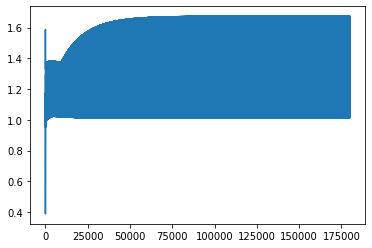

In [858]:
plt.plot(_)